<a href="https://www.kaggle.com/code/mohamedmoez2/image-caption-generator-flickr?scriptVersionId=136551920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import polars
import pickle
import os
import re
import cv2
import tensorflow as tf
import keras.models
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.layers import Bidirectional

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print('Number of GPUs available: ', len(physical_devices))

Number of GPUs available:  1


In [2]:
dataset_dir = './kaggle/input/flickr8k'
features_dir = './kaggle/input/flickr8k-features'
work_dir = './kaggle/working'
model_dir = './kaggle/input/icg-models'

In [3]:
# Load captions from captions.txt
captions_path = os.path.join(dataset_dir, 'captions.txt')
df = polars.read_csv(captions_path)
df.columns = ['image_id', 'caption']
# Remove file extension from image_id
df = df.with_columns([df['image_id'].str.split('.').apply(lambda x: x[0]).alias('image_id'), df['caption']])

In [4]:
# print example caption
df.filter(df['image_id'] == '10815824_2997e03d76')['caption'].to_list()

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 'A girl and her horse stand by a fire .',
 "A girl holding a horse 's lead behind a fire .",
 'A man , and girl and two horses are near a contained fire .',
 'Two people and two horses watching a fire .']

In [5]:
# Preprocess captions
def preprocess_caption(caption):
    # Check first if it's already preprocessed
    if caption.startswith('sseq') & caption.endswith('eseq'):
        return caption
    # Convert any uppercase to lowercase
    caption = caption.lower()
    # Remove special characters
    caption = re.sub(r'[^\w\s]', '', caption)
    # Add start and end tokens to the caption
    caption = 'sseq ' + caption + ' eseq'
    # Remove extra whitespaces or any single character
    caption = " ".join([word for word in caption.split() if len(word)>1])
    return caption

df = df.with_columns([df['image_id'], df['caption'].apply(preprocess_caption)])

In [6]:
# print example preprocessed caption
df.filter(df['image_id'] == '10815824_2997e03d76')['caption'].to_list()

['sseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel eseq',
 'sseq girl and her horse stand by fire eseq',
 'sseq girl holding horse lead behind fire eseq',
 'sseq man and girl and two horses are near contained fire eseq',
 'sseq two people and two horses watching fire eseq']

In [7]:
some_data = df.head(15)

n=0
for row in some_data.iter_rows(named=True):
    # print a new line if image_id is different
    if (n > 0) & (row['image_id'] != some_data['image_id'][n-1]):
        print()
        
    print(f"{row['image_id']}, {row['caption'].replace('sseq', '').replace('eseq', '').strip()}")
    n+=1

1000268201_693b08cb0e, child in pink dress is climbing up set of stairs in an entry way

1000268201_693b08cb0e, girl going into wooden building

1000268201_693b08cb0e, little girl climbing into wooden playhouse

1000268201_693b08cb0e, little girl climbing the stairs to her playhouse

1000268201_693b08cb0e, little girl in pink dress going into wooden cabin



1001773457_577c3a7d70, black dog and spotted dog are fighting

1001773457_577c3a7d70, black dog and tricolored dog playing with each other on the road

1001773457_577c3a7d70, black dog and white dog with brown spots are staring at each other in the street

1001773457_577c3a7d70, two dogs of different breeds looking at each other on the road

1001773457_577c3a7d70, two dogs on pavement moving toward each other



1002674143_1b742ab4b8, little girl covered in paint sits in front of painted rainbow with her hands in bowl

1002674143_1b742ab4b8, little girl is sitting in front of large painted rainbow

1002674143_1b742ab4b8, small girl

In [8]:
# Function to extract features from images using VGG16
def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x, verbose=0) # type: ignore
    return features

### Extract images features and store them

In [9]:
# images_features = {}
# image_dir = os.path.join(dataset_dir, 'Images')
# for img_id in tqdm(df['image_id'].unique()):
#     img_path = os.path.join(image_dir, f'{img_id}.jpg')
#     images_features[img_id] = extract_features(img_path)

In [10]:
# store features
# pickle.dump(images_features, open(os.path.join(work_dir, 'images_features.pkl'), 'wb'))

### Load features

In [11]:
with open(os.path.join(features_dir, 'images_features.pkl'), 'rb') as f:
    images_features = pickle.load(f)

In [12]:
# print example features
print(images_features['1002674143_1b742ab4b8'][0])

[1.4937937  0.         0.53567505 ... 2.3152392  3.741828   0.        ]


In [13]:
# # Function to visualize extracted features
# def visualize_features(img_path):
#     img = load_img(img_path)
#     features = extract_features(img_path)
# #     plt.imshow(img)
# #     plt.axis('off')
# #     plt.title('Input Image')
# #     plt.show()
#     plt.figure(figsize=(6, 3))
#     plt.plot(features[0])
#     plt.xlabel('Feature Index')
#     plt.ylabel('Feature Value')
#     plt.title('Image Features')
#     plt.show()

# # Example usage
# image_dir = os.path.join(dataset_dir, 'Images')
# img_path = os.path.join(image_dir, '1000268201_693b08cb0e.jpg')
# visualize_features(img_path)

In [14]:
# Split dataset into train, test, and validation sets
train_val, test_data = train_test_split(df, test_size=0.19996, shuffle=False)
train_data, val_data = train_test_split(df, test_size=0.1, random_state=False)

print('train', len(train_val))
print('val  ', len(val_data))
print('test ', len(test_data))

train 32365

val   4046

test  8090


### Tokenize caption words

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['caption'])
vocab_size = len(tokenizer.word_index) + 1
print("number of unique words: ", len(tokenizer.word_index))

number of unique words:  8403


### Save tokenizer in a CSV file

In [16]:
pd.DataFrame(tokenizer.word_index.items(), columns=['word', 'index']).to_csv(os.path.join(work_dir, 'words_indeces.csv'), index=False)

In [17]:
read_tokenizer = polars.read_csv(os.path.join(work_dir, 'words_indeces.csv'))
read_tokenizer.head(5)

shape: (5, 2)
┌──────┬───────┐
│ word ┆ index │
│ ---  ┆ ---   │
│ str  ┆ i64   │
╞══════╪═══════╡
│ sseq ┆ 1     │
│ eseq ┆ 2     │
│ in   ┆ 3     │
│ the  ┆ 4     │
│ on   ┆ 5     │
└──────┴───────┘

### Find the maximum caption length

In [18]:
max_caption_length = max(train_data['caption'].apply(lambda x: len(x.split())))
print("maximum caption length of data: ", max_caption_length)

maximum caption length of data:  34


In [19]:
some_train = train_val.tail(10)
some_test = test_data.tail(10)

n=0
for row in some_test.iter_rows(named=True):
    # print a new line if image_id is different
    if (n > 0) & (row['image_id'] != some_test['image_id'][n-1]):
        print()
        
    print(f"{row['image_id']}, {row['caption'].replace('sseq', '').replace('eseq', '').strip()}")
    n+=1

997338199_7343367d7f, person stands near golden walls

997338199_7343367d7f, woman behind scrolled wall is writing

997338199_7343367d7f, woman standing near decorated wall writes

997338199_7343367d7f, the walls are covered in gold and patterns

997338199_7343367d7f, woman writing on pad in room with gold decorated walls



997722733_0cb5439472, man in pink shirt climbs rock face

997722733_0cb5439472, man is rock climbing high in the air

997722733_0cb5439472, person in red shirt climbing up rock face covered in assist handles

997722733_0cb5439472, rock climber in red shirt

997722733_0cb5439472, rock climber practices on rock climbing wall


### Data generator (to be passed through the model training)

In [20]:
def data_generator(data, tokenizer, max_caption_length, batch_size):
    # Shuffle data
    data = data.sample(fraction=0.5, shuffle=True, seed=42)
    img_feature_list, current_words_list, next_word_list = [], [], []
    
    n = 0
    while True:
        for row in data.iter_rows(named=True):
            n += 1
            img_id, caption = row['image_id'], row['caption']
            img_features = images_features[img_id]
            actual_caption_seq = tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(actual_caption_seq)):
                current_words, next_word = actual_caption_seq[:i], actual_caption_seq[i]
                current_words = pad_sequences([current_words], maxlen=max_caption_length)[0]
                next_word = to_categorical([next_word], num_classes=vocab_size)[0]
                
                img_feature_list.append(img_features[0])
                current_words_list.append(current_words)
                next_word_list.append(next_word)
                
            if n == batch_size:
                yield ([np.array(img_feature_list), np.array(current_words_list)], np.array(next_word_list))
                img_feature_list, current_words_list, next_word_list = [], [], []
                n = 0

### Model architecture

In [21]:
image_feature_layers = Sequential([
    Dropout(0.4),
    Dense(256, activation='relu')
])

image_feature_layers.build(input_shape=(None, 4096))

In [22]:
caption_layers = Sequential([
    Embedding(vocab_size, 256, mask_zero=True, input_length=max_caption_length),
    Dropout(0.4),
    Bidirectional(LSTM(256, return_sequences=False))
])

caption_layers.build(input_shape=(None, max_caption_length))

In [23]:
# concatenate image and caption layers
merged = Concatenate()([image_feature_layers.output, caption_layers.output])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.4)(merged)
output_layer = Dense(vocab_size, activation='softmax')(merged)

# create model
icg_model = Model(inputs=[image_feature_layers.input, caption_layers.input], outputs=output_layer)

lr = 0.003
icg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

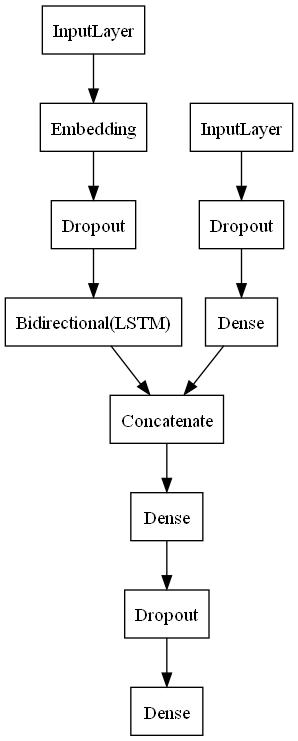

In [24]:
plot_model(icg_model, show_shapes=False, show_layer_names=False)

### Train the model

In [25]:
# Callbacks
model_path = os.path.join(work_dir, 'icg_model_v28.h5')
checkpoint = ModelCheckpoint(model_path, monitor='loss', save_best_only=True, mode='min', verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=lr, patience=6, mode='min', verbose=1) # type: ignore

In [26]:
batch_size = 100
train_steps = len(train_val) // batch_size
val_steps = len(val_data) // batch_size

train_generator = data_generator(train_val, tokenizer, max_caption_length, batch_size)
validation_generator = data_generator(val_data, tokenizer, max_caption_length, batch_size)

icg_model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    callbacks = [checkpoint, early_stopping],
    verbose = 1 # type: ignore
)

Epoch 1/50

323/323 [==============================] - 163s 484ms/step - loss: 4.6422 - accuracy: 0.2147 - val_loss: 3.7574 - val_accuracy: 0.2849

Epoch 2/50

323/323 [==============================] - 157s 486ms/step - loss: 3.6923 - accuracy: 0.2887 - val_loss: 3.4372 - val_accuracy: 0.3162

Epoch 3/50

323/323 [==============================] - 158s 488ms/step - loss: 3.3619 - accuracy: 0.3103 - val_loss: 3.3244 - val_accuracy: 0.3320

Epoch 4/50

323/323 [==============================] - 157s 488ms/step - loss: 3.1530 - accuracy: 0.3248 - val_loss: 3.2632 - val_accuracy: 0.3400

Epoch 5/50

323/323 [==============================] - 158s 490ms/step - loss: 2.9880 - accuracy: 0.3360 - val_loss: 3.2611 - val_accuracy: 0.3515

Epoch 6/50

323/323 [==============================] - 158s 489ms/step - loss: 2.8656 - accuracy: 0.3471 - val_loss: 3.2492 - val_accuracy: 0.3570

Epoch 7/50

323/323 [==============================] - 158s 491ms/step - loss: 2.7582 - accuracy: 0.3586 - val_l

In [27]:
#icg_model.save(model_path)

In [28]:
icg_model = keras.models.load_model(model_path)

### Function to generate caption for an image

In [29]:
def generate_caption(model, tokenizer, img_features, max_caption_length):
    
    caption = 'sseq'
    
    for i in range(max_caption_length):
        
        caption_sequence = tokenizer.texts_to_sequences([caption])[0]
        
        caption_sequence = pad_sequences([caption_sequence], maxlen=max_caption_length)
        
        predictions = model.predict([img_features, caption_sequence], verbose=0)
        
        predicted_index = np.argmax(predictions)
        
        word = tokenizer.index_word[predicted_index]
        
        caption += ' ' + word
        
        if word == 'eseq':
            break
        
    return caption

### Testing the model

In [30]:
train_img1 = os.path.join(dataset_dir, 'Images/1003163366_44323f5815.jpg')
train_img6 = os.path.join(dataset_dir, 'Images/1436760519_8d6101a0ed.jpg')
train_img7 = os.path.join(dataset_dir, 'Images/2911928620_06c3fa293e.jpg')
train_img8 = os.path.join(dataset_dir, 'Images/2086678529_b3301c2d71.jpg')
train_img9 = os.path.join(dataset_dir, 'Images/10815824_2997e03d76.jpg')

test_img2 = os.path.join(dataset_dir, 'Images/3759492488_592cd78ed1.jpg')
test_img3 = os.path.join(dataset_dir, 'Images/97406261_5eea044056.jpg')
test_img4 = os.path.join(dataset_dir, 'Images/3697003897_d8ac13be9a.jpg')
test_img5 = os.path.join(dataset_dir, 'Images/3765374230_cb1bbee0cb.jpg')
test_img10 = os.path.join(dataset_dir, 'Images/42637986_135a9786a6.jpg')
test_img11 = os.path.join(dataset_dir, 'Images/44129946_9eeb385d77.jpg')
test_img12 = os.path.join(dataset_dir, 'Images/44856031_0d82c2c7d1.jpg')
test_img13 = os.path.join(dataset_dir, 'Images/47870024_73a4481f7d.jpg')
test_img14 = os.path.join(dataset_dir, 'Images/3728695560_00ec1ca492.jpg')
test_img15 = os.path.join(dataset_dir, 'Images/3739833689_a0038545bd.jpg')

# 2 Train samples

# 3601533527_6c2439113c, man is partially silhouetted and leaning against dark object

# 3601569729_bf4bf82768, group of race horses run down track carrying jockeys


test_img1_test = os.path.join(dataset_dir, 'Images/989754491_7e53fb4586.jpg')
test_img2_test = os.path.join(dataset_dir, 'Images/989851184_9ef368e520.jpg')
test_img3_test = os.path.join(dataset_dir, 'Images/990890291_afc72be141.jpg')
test_img4_test = os.path.join(dataset_dir, 'Images/99171998_7cc800ceef.jpg')
test_img5_test = os.path.join(dataset_dir, 'Images/99679241_adc853a5c0.jpg')
test_img6_test = os.path.join(dataset_dir, 'Images/997338199_7343367d7f.jpg')
test_img7_test = os.path.join(dataset_dir, 'Images/997722733_0cb5439472.jpg')

In [31]:
# Load VGG16 model and remove the last layer
base_model = VGG16()
base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

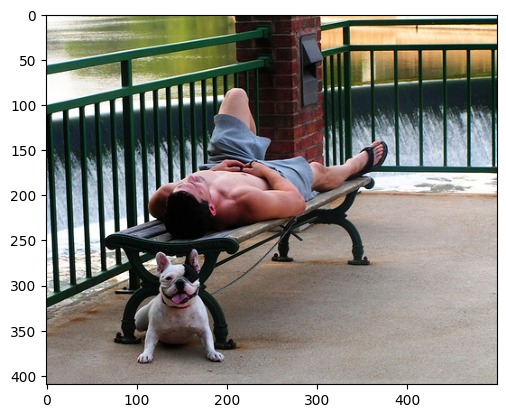

'sseq two dogs are playing in the grass eseq'

In [32]:
plt.imshow(np.asarray(Image.open(train_img1)))
plt.show()
img_features = extract_features(train_img1)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

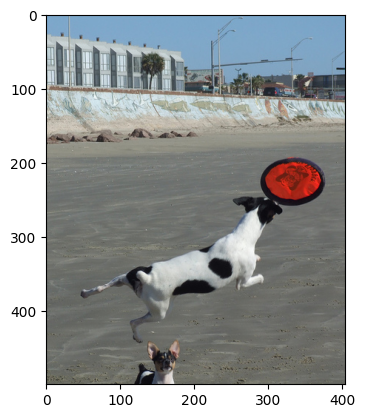

'sseq dog is running through the water eseq'

In [60]:
plt.imshow(np.asarray(Image.open(train_img6)))
plt.show()
img_features = extract_features(train_img6)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

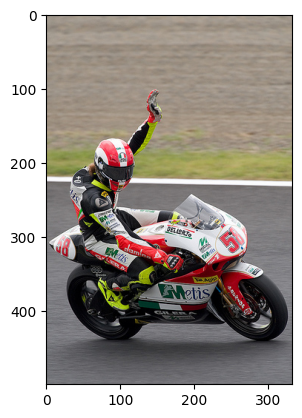

'sseq motorcyclist pops wheelie in the dirt eseq'

In [59]:
plt.imshow(np.asarray(Image.open(train_img7)))
plt.show()
img_features = extract_features(train_img7)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

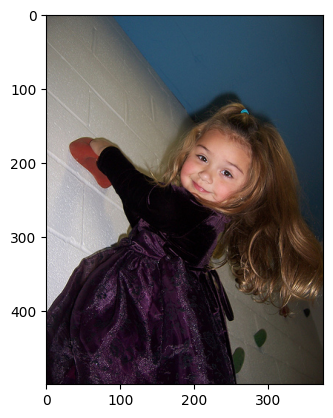

'sseq young boy in blue shirt is playing in the water eseq'

In [35]:
plt.imshow(np.asarray(Image.open(train_img8)))
plt.show()
img_features = extract_features(train_img8)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

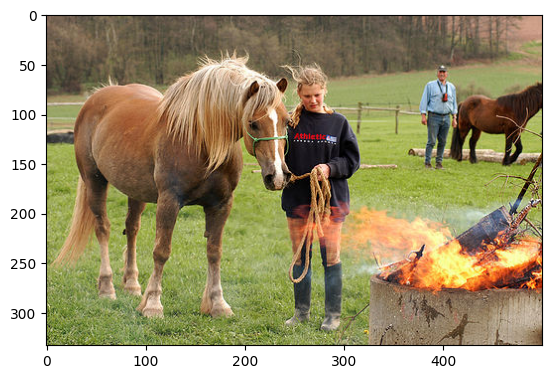

'sseq two dogs are running on the track eseq'

In [36]:
plt.imshow(np.asarray(Image.open(train_img9)))
plt.show()
img_features = extract_features(train_img9)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

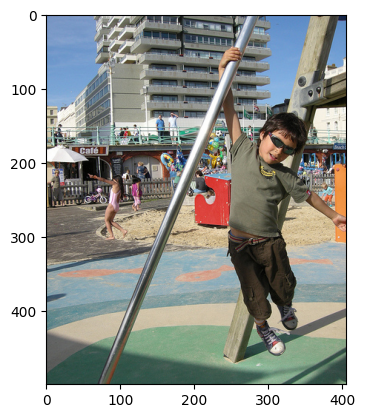

'sseq man in red shirt is standing on the grass eseq'

In [37]:
plt.imshow(np.asarray(Image.open(test_img2)))
plt.show()
img_features = extract_features(test_img2)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

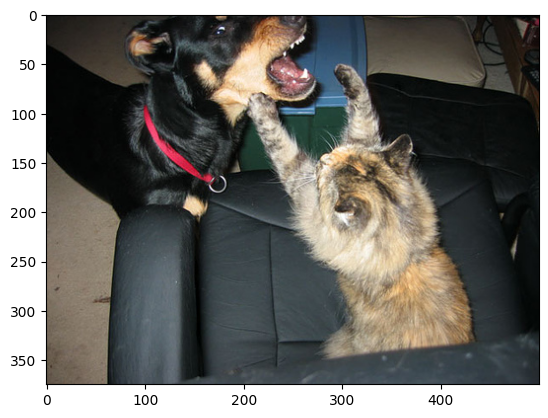

'sseq dog is running on the grass eseq'

In [58]:
plt.imshow(np.asarray(Image.open(test_img3)))
plt.show()
img_features = extract_features(test_img3)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

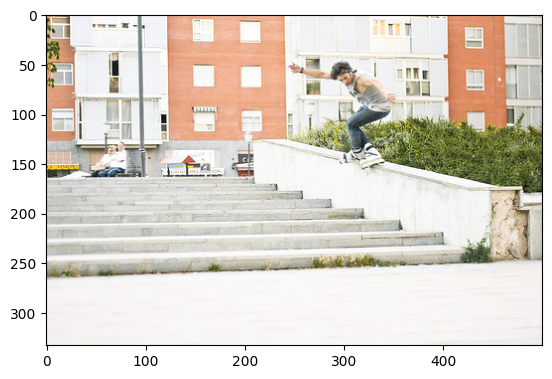

'sseq man in red shirt is doing trick on skateboard eseq'

In [39]:
plt.imshow(np.asarray(Image.open(test_img4)))
plt.show()
img_features = extract_features(test_img4)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

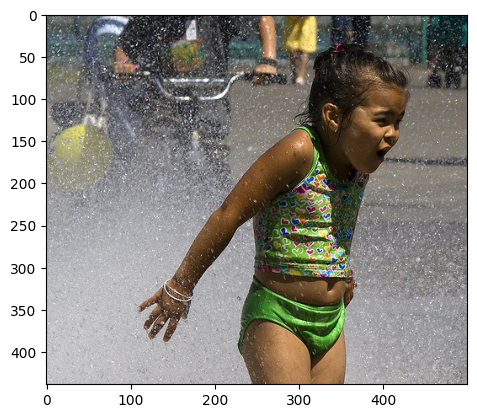

'sseq young girl in blue bathing suit is playing in the water eseq'

In [40]:
plt.imshow(np.asarray(Image.open(test_img5)))
plt.show()
img_features = extract_features(test_img5)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

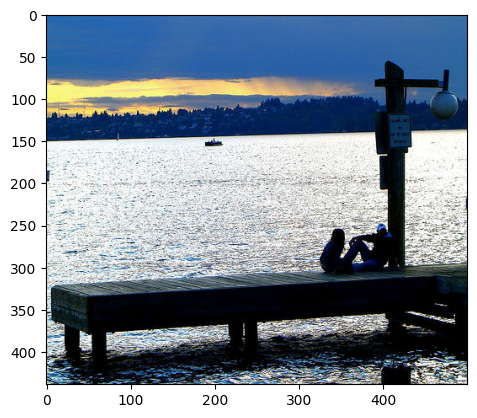

'sseq man in red jacket is standing on the shore of the ocean eseq'

In [57]:
plt.imshow(np.asarray(Image.open(test_img10)))
plt.show()
img_features = extract_features(test_img10)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

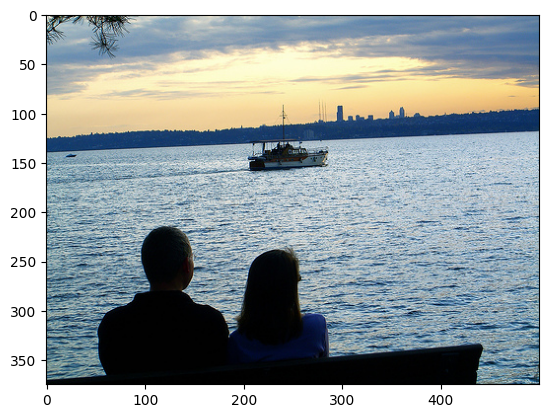

'sseq man in blue shorts is standing on the shore of the ocean eseq'

In [42]:
plt.imshow(np.asarray(Image.open(test_img11)))
plt.show()
img_features = extract_features(test_img11)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

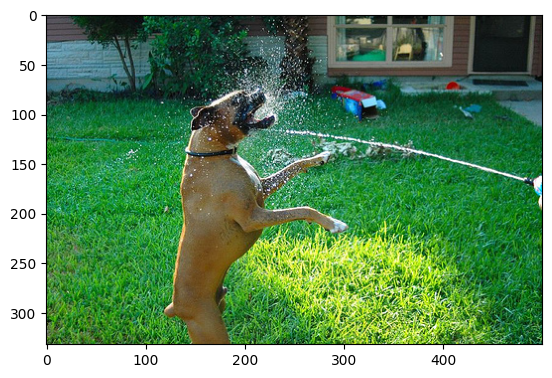

'sseq two dogs are running through the grass eseq'

In [43]:
plt.imshow(np.asarray(Image.open(test_img12)))
plt.show()
img_features = extract_features(test_img12)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

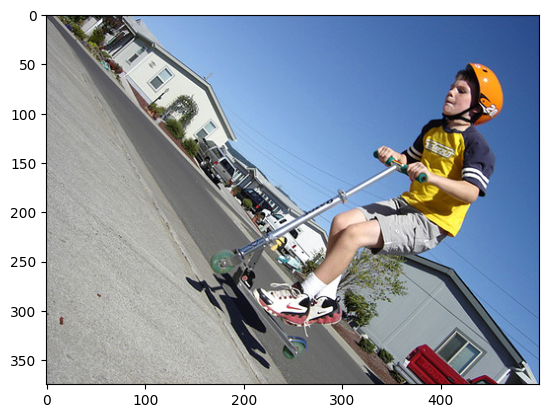

'sseq man in blue shirt is doing trick on snowboard eseq'

In [56]:
plt.imshow(np.asarray(Image.open(test_img13)))
plt.show()
img_features = extract_features(test_img13)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

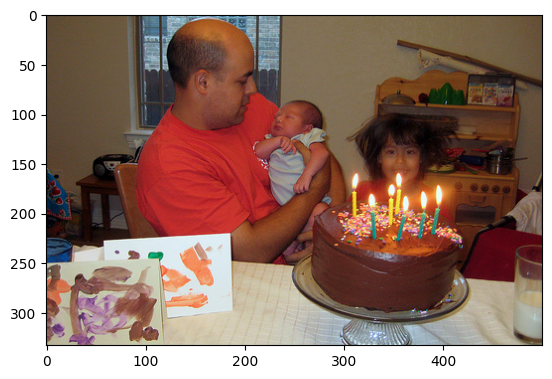

'sseq two young women in blue dress with pink flowers eseq'

In [45]:
plt.imshow(np.asarray(Image.open(test_img14)))
plt.show()
img_features = extract_features(test_img14)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

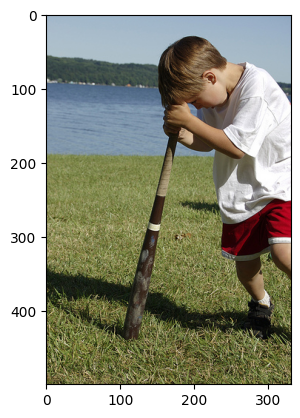

'sseq young girl in pink dress is playing with red ball eseq'

In [46]:
plt.imshow(np.asarray(Image.open(test_img15)))
plt.show()
img_features = extract_features(test_img15)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

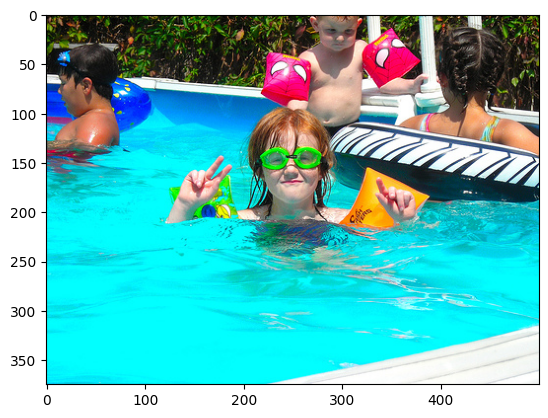

'sseq the young girl is swimming swimming swimming pool with water eseq'

In [47]:
plt.imshow(np.asarray(Image.open(test_img1_test)))
plt.show()
img_features = extract_features(test_img1_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

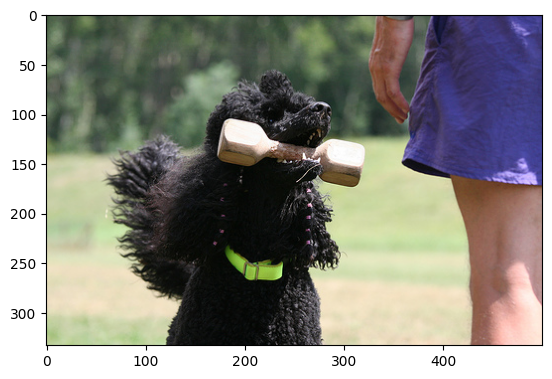

'sseq two young boys are playing in the grass eseq'

In [48]:
plt.imshow(np.asarray(Image.open(test_img2_test)))
plt.show()
img_features = extract_features(test_img2_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

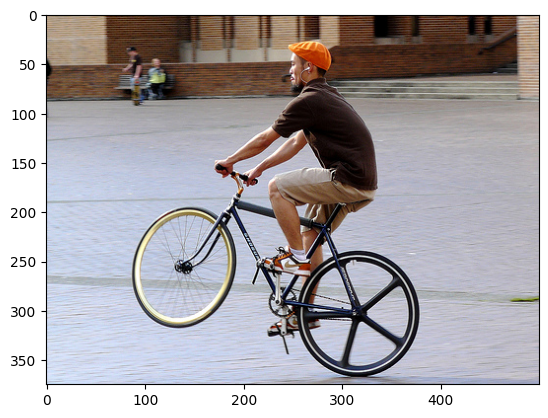

'sseq man in red jacket and bomber hat is standing on the sidewalk eseq'

In [49]:
plt.imshow(np.asarray(Image.open(test_img3_test)))
plt.show()
img_features = extract_features(test_img3_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

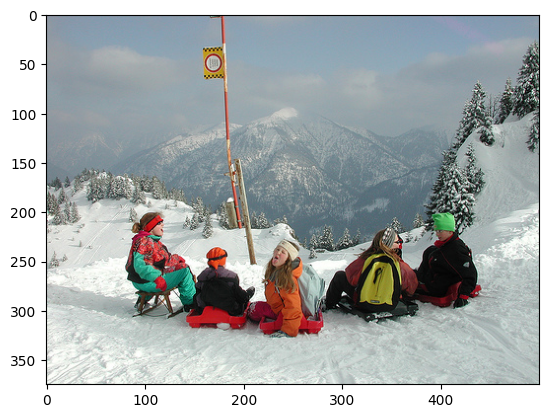

'sseq man in red jacket is skiing down steep slope eseq'

In [50]:
plt.imshow(np.asarray(Image.open(test_img4_test)))
plt.show()
img_features = extract_features(test_img4_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

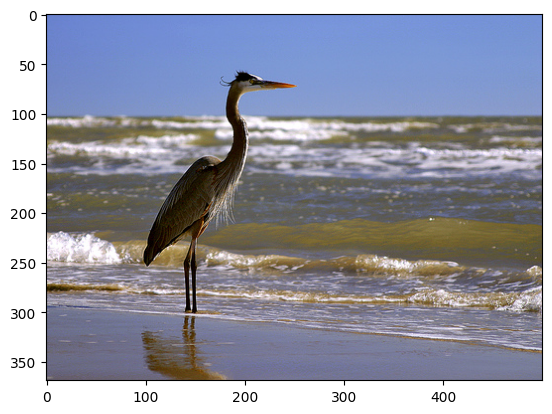

'sseq man in red shorts is standing on the shore of the water eseq'

In [51]:
plt.imshow(np.asarray(Image.open(test_img5_test)))
plt.show()
img_features = extract_features(test_img5_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

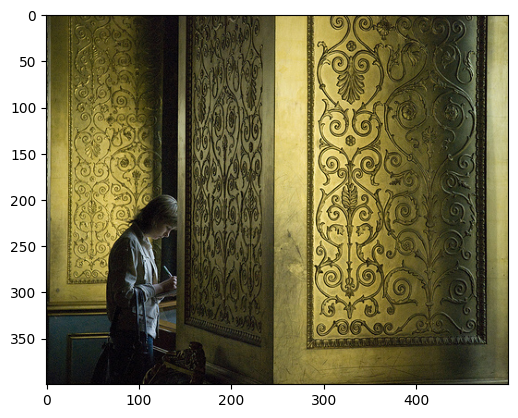

'sseq man in blue shirt is standing in front of brick wall eseq'

In [52]:
plt.imshow(np.asarray(Image.open(test_img6_test)))
plt.show()
img_features = extract_features(test_img6_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

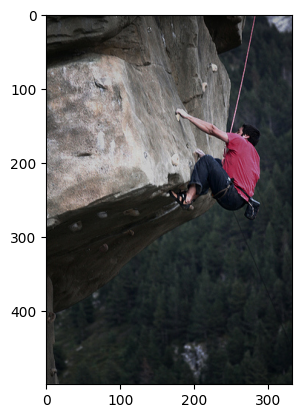

'sseq man is climbing rock wall eseq'

In [53]:
plt.imshow(np.asarray(Image.open(test_img7_test)))
plt.show()
img_features = extract_features(test_img7_test)
generate_caption(icg_model, tokenizer, img_features, max_caption_length)

# Evaluate the model with BLEU score

In [54]:
from nltk.translate.bleu_score import corpus_bleu

def BLEU_evaluate(test_data, icg_model, tokenizer, max_caption_length):
    actual_captions_list = []
    predicted_caption_list = []
    
    for img_id in tqdm(test_data['image_id'].unique()):
        actual_captions = []
        for caption in test_data.filter(test_data['image_id'] == f'{img_id}')['caption']:
            actual_captions.append(caption)
        
        predicted_caption = generate_caption(icg_model, tokenizer, images_features[f'{img_id}'], max_caption_length)
        
        predicted_caption_list.append(predicted_caption)
        actual_captions_list.append(actual_captions)
    
    print("BLEU-1: %f" %corpus_bleu(actual_captions_list, predicted_caption_list, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" %corpus_bleu(actual_captions_list, predicted_caption_list, weights=(0.5, 0.5, 0, 0)))

In [55]:
BLEU_evaluate(test_data, icg_model, tokenizer, max_caption_length)

  0%|          | 0/1618 [00:00<?, ?it/s]

BLEU-1: 0.928166

BLEU-2: 0.824395
